In [196]:
import tensorflow as tf
import numpy as np
import pandas as pd

In [197]:
mnist = tf.keras.datasets.mnist 


In [198]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
x_train, x_test = X_train / 255.0, X_test / 255.0

In [199]:
y_train[0:5]

array([5, 0, 4, 1, 9], dtype=uint8)

In [200]:
print("categorical labels")
print(y_train[0:5])

# make labels one hot encoded
y_train = tf.one_hot(y_train, 10)
y_test = tf.one_hot(y_test, 10)

print("one hot encoded labels")
print(y_train[0:5])

categorical labels
[5 0 4 1 9]
one hot encoded labels
tf.Tensor(
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]], shape=(5, 10), dtype=float32)


In [201]:
print("Number of training example : ", X_train.shape[0])
print("Number of test examples : ", X_test.shape[0])

Number of training example :  60000
Number of test examples :  10000


In [172]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(50)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(50)


In [202]:
width = 28 # width of the image in pixels 
height = 28 # height of the image in pixels
flat = width * height # number of pixels in one image 
class_output = 10 # number of possible classifications for the problem

In [203]:
x_image_train = tf.reshape(x_train, [-1,28,28,1])  
x_image_train = tf.cast(x_image_train, 'float32') 

x_image_test = tf.reshape(x_test, [-1,28,28,1]) 
x_image_test = tf.cast(x_image_test, 'float32') 

#creating new dataset with reshaped inputs
train_ds2 = tf.data.Dataset.from_tensor_slices((x_image_train, y_train)).batch(50)
test_ds2 = tf.data.Dataset.from_tensor_slices((x_image_test, y_test)).batch(50)

In [204]:
x_image_train = tf.slice(x_image_train,[0,0,0,0],[10000, 28, 28, 1])
y_train = tf.slice(y_train,[0,0],[10000, 10])

# Convolutional Layer 1

In [205]:
W_conv1 = tf.Variable(tf.random.truncated_normal([5, 5, 1, 32], stddev=0.1, seed=0))
b_conv1 = tf.Variable(tf.constant(0.1, shape=[32])) # need 32 biases for 32 outputs

In [206]:
def convolve1(x):
    return(
        tf.nn.conv2d(x, W_conv1, strides=[1, 1, 1, 1], padding='SAME') + b_conv1)

In [207]:
def h_conv1(x): return(tf.nn.relu(convolve1(x)))

## Max Pooling
After convolutional layer, need to pool together values gathered by the filters in the covolutional layer

In [208]:
def conv1(x):
    return tf.nn.max_pool(h_conv1(x), ksize=[1, 2, 2, 1], 
                          strides=[1, 2, 2, 1], padding='SAME')

# Convolutional Layer 2

In [209]:
W_conv2 = tf.Variable(tf.random.truncated_normal([5, 5, 32, 64], stddev=0.1, seed=1))
b_conv2 = tf.Variable(tf.constant(0.1, shape=[64])) #need 64 biases for 64 outputs

In [210]:
def convolve2(x): 
    return( 
    tf.nn.conv2d(conv1(x), W_conv2, strides=[1, 1, 1, 1], padding='SAME') + b_conv2)

In [211]:

def h_conv2(x):  return tf.nn.relu(convolve2(x))

In [212]:

def conv2(x):  
    return(
    tf.nn.max_pool(h_conv2(x), ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME'))

# Full Connected Layer

In [213]:

def layer2_matrix(x): return tf.reshape(conv2(x), [-1, 7 * 7 * 64])

In [214]:
W_fc1 = tf.Variable(tf.random.truncated_normal([7 * 7 * 64, 1024], stddev=0.1, seed = 2))
b_fc1 = tf.Variable(tf.constant(0.1, shape=[1024])) # need 1024 biases for 1024 outputs

In [215]:
def fcl(x): return tf.matmul(layer2_matrix(x), W_fc1) + b_fc1

In [216]:
def h_fc1(x): return tf.nn.relu(fcl(x))

## Dropout layer
Common in CNNs or NNets with tons of nodes, we need a way of forgetting features to prevent **overfitting**

In [217]:
keep_prob=0.5
def layer_drop(x): return tf.nn.dropout(h_fc1(x), keep_prob)

# Softmax Layer

In [218]:
W_fc2 = tf.Variable(tf.random.truncated_normal([1024, 10], stddev=0.1, seed = 2)) #1024 neurons
b_fc2 = tf.Variable(tf.constant(0.1, shape=[10])) # 10 possibilities for digits [0,1,2,3,4,5,6,7,8,9]

In [219]:
def fc(x): return tf.matmul(layer_drop(x), W_fc2) + b_fc2

In [220]:

def y_CNN(x): return tf.nn.softmax(fc(x))

# Loss Function : Cross Entropy

In [221]:
def cross_entropy(y_label, y_pred):
    return (-tf.reduce_sum(y_label * tf.math.log(y_pred + 1.e-10)))

In [222]:
optimizer = tf.keras.optimizers.Adam(1e-4)

In [223]:
variables = [W_conv1, b_conv1, W_conv2, b_conv2, 
             W_fc1, b_fc1, W_fc2, b_fc2, ]

def train_step(x, y):
    with tf.GradientTape() as tape:
        current_loss = cross_entropy( y, y_CNN( x ))
        grads = tape.gradient( current_loss , variables )
        optimizer.apply_gradients( zip( grads , variables ) )
        return current_loss.numpy()

In [224]:
correct_prediction = tf.equal(tf.argmax(y_CNN(x_image_train), axis=1), tf.argmax(y_train, axis=1))

In [225]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float32'))

In [226]:
loss_values=[]
accuracies = []
epochs = 1

for i in range(epochs):
    j=0
    # each batch has 50 examples
    for x_train_batch, y_train_batch in train_ds2:
        j+=1
        current_loss = train_step(x_train_batch, y_train_batch)
        if j%50==0: #reporting intermittent batch statistics
            correct_prediction = tf.equal(tf.argmax(y_CNN(x_train_batch), axis=1),
                                  tf.argmax(y_train_batch, axis=1))
            #  accuracy
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()
            print("epoch ", str(i), "batch", str(j), "loss:", str(current_loss),
                     "accuracy", str(accuracy)) 
            
    current_loss = cross_entropy( y_train, y_CNN( x_image_train )).numpy()
    loss_values.append(current_loss)
    correct_prediction = tf.equal(tf.argmax(y_CNN(x_image_train), axis=1),
                                  tf.argmax(y_train, axis=1))
    #  accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()
    accuracies.append(accuracy)
    print("end of epoch ", str(i), "loss", str(current_loss), "accuracy", str(accuracy) ) 

epoch  0 batch 50 loss: 117.88733 accuracy 0.48
epoch  0 batch 100 loss: 66.99368 accuracy 0.66
epoch  0 batch 150 loss: 35.963657 accuracy 0.76
epoch  0 batch 200 loss: 15.638382 accuracy 0.88
epoch  0 batch 250 loss: 36.595947 accuracy 0.92
epoch  0 batch 300 loss: 21.993021 accuracy 0.82
epoch  0 batch 350 loss: 30.65656 accuracy 0.82
epoch  0 batch 400 loss: 19.087582 accuracy 0.94
epoch  0 batch 450 loss: 19.908253 accuracy 0.8
epoch  0 batch 500 loss: 12.522513 accuracy 0.9
epoch  0 batch 550 loss: 15.900955 accuracy 0.9
epoch  0 batch 600 loss: 16.292875 accuracy 0.84
epoch  0 batch 650 loss: 16.372456 accuracy 0.84
epoch  0 batch 700 loss: 6.060528 accuracy 0.98
epoch  0 batch 750 loss: 18.423653 accuracy 0.82
epoch  0 batch 800 loss: 11.51819 accuracy 0.94
epoch  0 batch 850 loss: 15.833534 accuracy 0.94
epoch  0 batch 900 loss: 18.147957 accuracy 0.88
epoch  0 batch 950 loss: 14.353401 accuracy 0.88
epoch  0 batch 1000 loss: 11.425291 accuracy 0.96
epoch  0 batch 1050 loss: 1

# Visualization


In [227]:

def scale_to_unit_interval(ndar, eps=1e-8):
    """ Scales all values in the ndarray ndar to be between 0 and 1 """
    ndar = ndar.copy()
    ndar -= ndar.min()
    ndar *= 1.0 / (ndar.max() + eps)
    return ndar

In [228]:
def tile_raster_images(X, img_shape, tile_shape, tile_spacing=(0, 0),
                       scale_rows_to_unit_interval=True,
                       output_pixel_vals=True):
    """
    Transform an array with one flattened image per row, into an array in
    which images are reshaped and layed out like tiles on a floor.
    This function is useful for visualizing datasets whose rows are images,
    and also columns of matrices for transforming those rows
    (such as the first layer of a neural net).
    :type X: a 2-D ndarray or a tuple of 4 channels, elements of which can
    be 2-D ndarrays or None;
    :param X: a 2-D array in which every row is a flattened image.
    :type img_shape: tuple; (height, width)
    :param img_shape: the original shape of each image
    :type tile_shape: tuple; (rows, cols)
    :param tile_shape: the number of images to tile (rows, cols)
    :param output_pixel_vals: if output should be pixel values (i.e. int8
    values) or floats
    :param scale_rows_to_unit_interval: if the values need to be scaled before
    being plotted to [0,1] or not
    :returns: array suitable for viewing as an image.
    (See:`Image.fromarray`.)
    :rtype: a 2-d array with same dtype as X.
    """

    assert len(img_shape) == 2
    assert len(tile_shape) == 2
    assert len(tile_spacing) == 2

    # The expression below can be re-written in a more C style as
    # follows :
    #
    # out_shape    = [0,0]
    # out_shape[0] = (img_shape[0]+tile_spacing[0])*tile_shape[0] -
    #                tile_spacing[0]
    # out_shape[1] = (img_shape[1]+tile_spacing[1])*tile_shape[1] -
    #                tile_spacing[1]
    out_shape = [
        (ishp + tsp) * tshp - tsp
        for ishp, tshp, tsp in zip(img_shape, tile_shape, tile_spacing)
    ]

    if isinstance(X, tuple):
        assert len(X) == 4
        # Create an output numpy ndarray to store the image
        if output_pixel_vals:
            out_array = np.zeros((out_shape[0], out_shape[1], 4),
                                    dtype='uint8')
        else:
            out_array = np.zeros((out_shape[0], out_shape[1], 4),
                                    dtype=X.dtype)

        #colors default to 0, alpha defaults to 1 (opaque)
        if output_pixel_vals:
            channel_defaults = [0, 0, 0, 255]
        else:
            channel_defaults = [0., 0., 0., 1.]

        for i in range(4):
            if X[i] is None:
                # if channel is None, fill it with zeros of the correct
                # dtype
                dt = out_array.dtype
                if output_pixel_vals:
                    dt = 'uint8'
                out_array[:, :, i] = np.zeros(
                    out_shape,
                    dtype=dt
                ) + channel_defaults[i]
            else:
                # use a recurrent call to compute the channel and store it
                # in the output
                out_array[:, :, i] = tile_raster_images(
                    X[i], img_shape, tile_shape, tile_spacing,
                    scale_rows_to_unit_interval, output_pixel_vals)
        return out_array

    else:
        # if we are dealing with only one channel
        H, W = img_shape
        Hs, Ws = tile_spacing

        # generate a matrix to store the output
        dt = X.dtype
        if output_pixel_vals:
            dt = 'uint8'
        out_array = np.zeros(out_shape, dtype=dt)

        for tile_row in range(tile_shape[0]):
            for tile_col in range(tile_shape[1]):
                if tile_row * tile_shape[1] + tile_col < X.shape[0]:
                    this_x = X[tile_row * tile_shape[1] + tile_col]
                    if scale_rows_to_unit_interval:
                        # if we should scale values to be between 0 and 1
                        # do this by calling the `scale_to_unit_interval`
                        # function
                        this_img = scale_to_unit_interval(
                            this_x.reshape(img_shape))
                    else:
                        this_img = this_x.reshape(img_shape)
                    # add the slice to the corresponding position in the
                    # output array
                    c = 1
                    if output_pixel_vals:
                        c = 255
                    out_array[
                        tile_row * (H + Hs): tile_row * (H + Hs) + H,
                        tile_col * (W + Ws): tile_col * (W + Ws) + W
                    ] = this_img * c
        return out_array

In [229]:
kernels = tf.reshape(tf.transpose(W_conv1, perm=[2, 3, 0,1]),[32, -1])

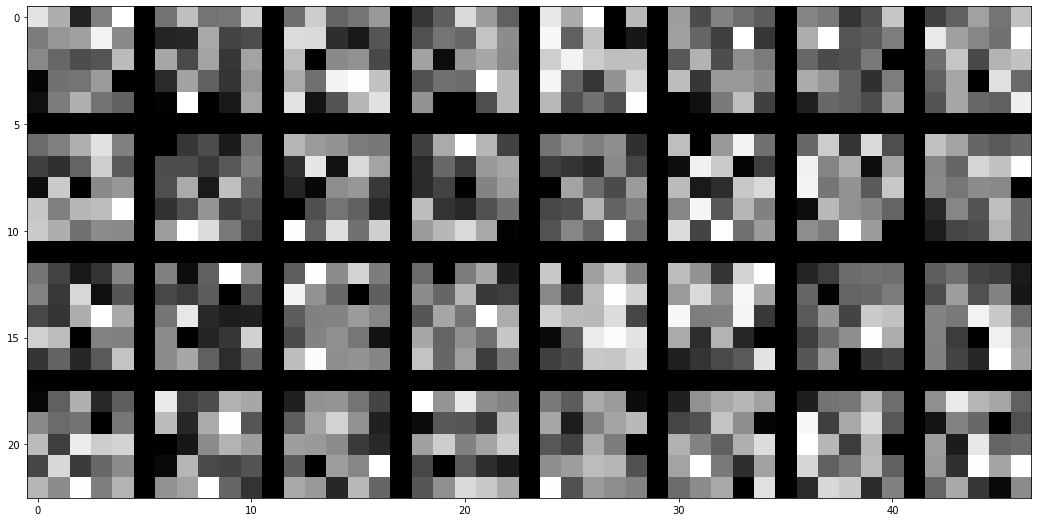

In [230]:
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
image = Image.fromarray(tile_raster_images(kernels.numpy(), img_shape=(5, 5) ,tile_shape=(4, 8), tile_spacing=(1, 1)))
### Plot image
plt.rcParams['figure.figsize'] = (18.0, 18.0)
imgplot = plt.imshow(image)
imgplot.set_cmap('gray')  

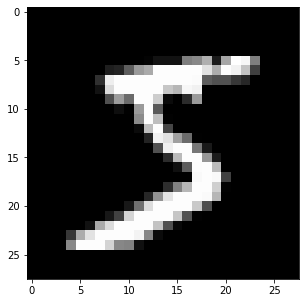

In [233]:
import numpy as np
plt.rcParams['figure.figsize'] = (5.0, 5.0)
sampleimage = [x_image_train[0]]
plt.imshow(np.reshape(sampleimage,[28,28]), cmap="gray")

## First Convolutional Layer Feature Extraction


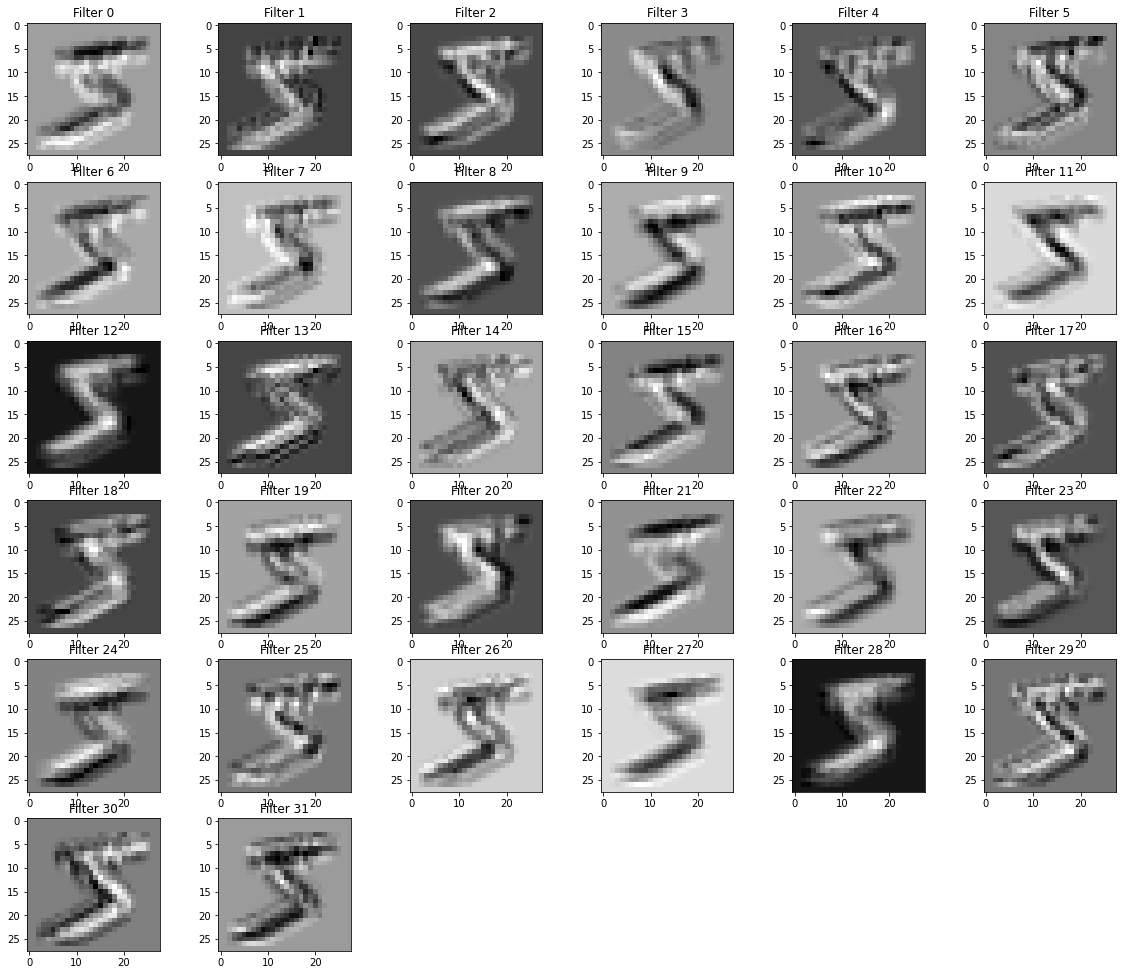

In [238]:
keep_prob=1.0
sampleimage = np.asarray(sampleimage)
ActivatedUnits = convolve1(sampleimage)                     
filters = ActivatedUnits.shape[3]
plt.figure(1, figsize=(20,20))
n_columns = 6
n_rows = np.math.ceil(filters / n_columns) + 1
for i in range(filters):
    plt.subplot(n_rows, n_columns, i+1)
    plt.title('Filter ' + str(i))
    plt.imshow(ActivatedUnits[0,:,:,i], interpolation="nearest", cmap="gray")

## Second Convolutional Layer Feature Extraction



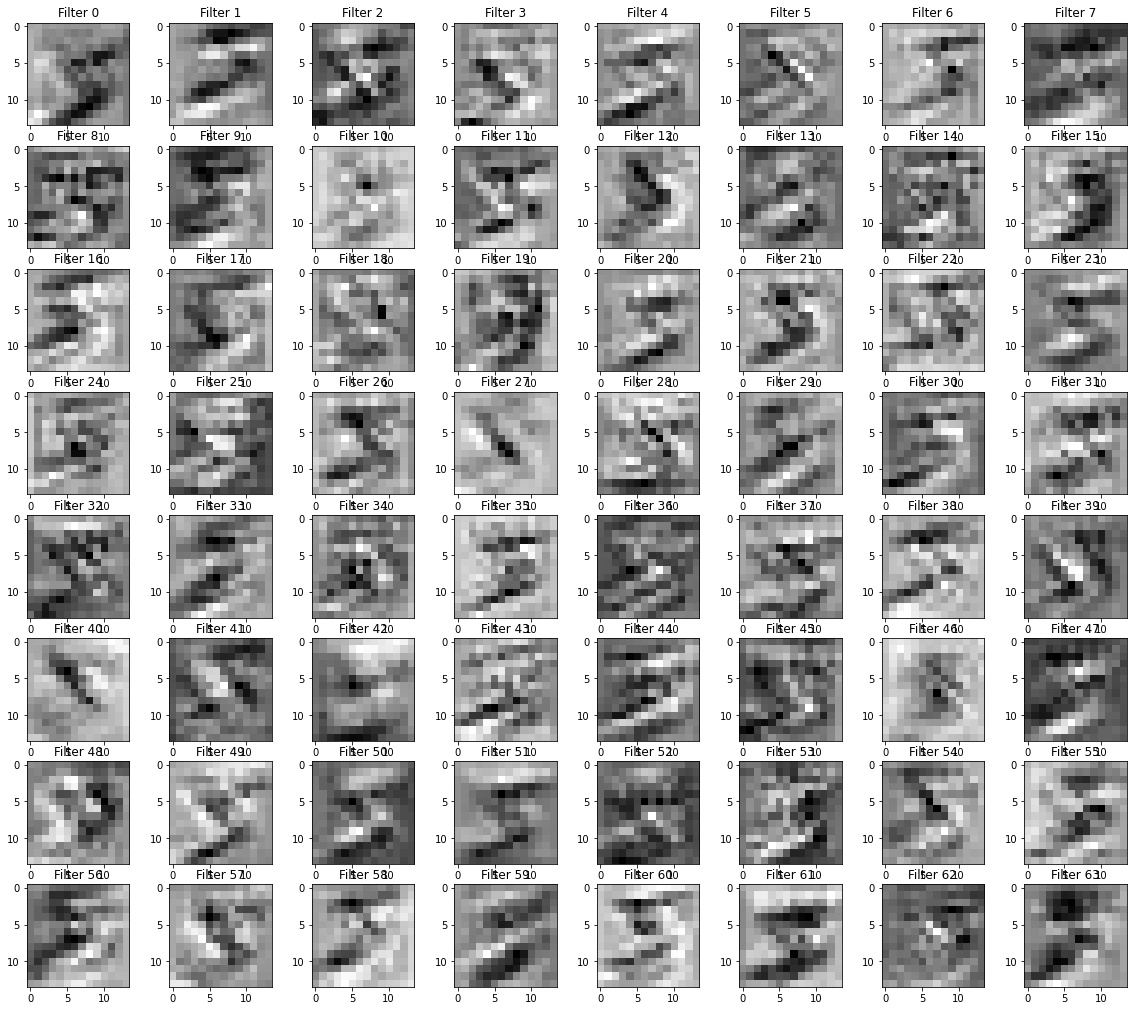

In [239]:
sampleimage = np.asarray(sampleimage)
ActivatedUnits = convolve2(sampleimage)
filters = ActivatedUnits.shape[3]
plt.figure(1, figsize=(20,20))
n_columns = 8
n_rows = np.math.ceil(filters / n_columns) + 1
for i in range(filters):
    plt.subplot(n_rows, n_columns, i+1)
    plt.title('Filter ' + str(i))
    plt.imshow(ActivatedUnits[0,:,:,i], interpolation="nearest", cmap="gray")